# Deep Learning and Neural Network - Question 2
## Arian Firoozi - 810100196
## Arman Majidi - 810100205

# Outline
- [ 0 - Packages ](#0)
- [ 1 - Data Proprocessing ](#1)
- [ 2 - Implementation ](#2)
- [ 3 - Result Analysis ](#3)

---

<a name="0"></a>
## 0 - Packages

First, let's run the cell below to import all the packages.
- [numpy](https://numpy.org) is the fundamental package for working with matrices in Python.
- [matplotlib](http://matplotlib.org) is a famous library to plot graphs in Python.
- [seanborn](https://seaborn.pydata.org) is a Python data visualization library based on matplotlib.
- [tensorflow](https://tensorflow.org) is an end-to-end platform for machine learning.
- [scikit-learn](https://scikit-learn.org) is a Python module for machine learning.
- [albumentations](https://albumentations.ai) is a computer vision tool that boosts the performance of deep convolutional neural networks.

In [1]:
import os
import random
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import json
from collections import Counter
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Dropout, Add, Lambda
from tensorflow.keras.models import Model

np.random.seed(42)

---

<a name="1"></a>
## 1 - Dataset Preparation

### ◆ Dataset Choosing

#### load random images with captions

In [2]:
def load_flickr8k_and_show_random_images(image_folder, captions_file, num_images):
    captions = {}
    with open(captions_file, 'r') as file:
        for line in file:
            parts = line.strip().split("#")
            image_file = parts[0].strip()
            caption = parts[1].split('\t')[1].strip()
            if image_file not in captions:
                captions[image_file] = []
            captions[image_file].append(caption)
    image_files = [f for f in os.listdir(image_folder) if f.endswith('.jpg')]
    random_images = random.sample(image_files, min(num_images, len(image_files)))
    plt.figure(figsize=(15, 5))
    for i, image_file in enumerate(random_images):
        image_path = os.path.join(image_folder, image_file)
        image = Image.open(image_path)
        plt.subplot(1, num_images, i + 1)
        plt.imshow(image)
        plt.axis('off')
        plt.title("\n".join(captions.get(image_file, ["No caption"])), fontsize=8)
    plt.tight_layout()
    plt.show()

In [3]:
def load_flickr8k_and_show_random_images_colab(image_folder, captions_file, num_images):
    captions = {}
    with open(captions_file, 'r') as file:
        for line in file:
            if line.startswith("image"):
                continue
            parts = line.strip().split(".jpg,")
            image_file = parts[0].strip()
            image_file=f'{image_file}.jpg'
            # print(line)
            caption = parts[1].strip()
            if image_file not in captions:
                captions[image_file] = []
            captions[image_file].append(caption)
    image_files = [f for f in os.listdir(image_folder) if f.endswith('.jpg')]
    random_images = random.sample(image_files, min(num_images, len(image_files)))
    plt.figure(figsize=(15, 5))
    for i, image_file in enumerate(random_images):
        image_path = os.path.join(image_folder, image_file)
        image = Image.open(image_path)
        plt.subplot(1, num_images, i + 1)
        plt.imshow(image)
        plt.axis('off')
        plt.title("\n".join(captions.get(image_file, ["No caption"])), fontsize=8)
    plt.tight_layout()
    plt.show()

Streaming output truncated to the last 5000 lines.
  inflating: flickr8k/Images/2844846111_8c1cbfc75d.jpg  
  inflating: flickr8k/Images/2844963839_ff09cdb81f.jpg  
  inflating: flickr8k/Images/2845246160_d0d1bbd6f0.jpg  
  inflating: flickr8k/Images/2845691057_d4ab89d889.jpg  
  inflating: flickr8k/Images/2845845721_d0bc113ff7.jpg  
  inflating: flickr8k/Images/2846037553_1a1de50709.jpg  
  inflating: flickr8k/Images/2846785268_904c5fcf9f.jpg  
  inflating: flickr8k/Images/2846843520_b0e6211478.jpg  
  inflating: flickr8k/Images/2847514745_9a35493023.jpg  
  inflating: flickr8k/Images/2847615962_c330bded6e.jpg  
  inflating: flickr8k/Images/2847859796_4d9cb0d31f.jpg  
  inflating: flickr8k/Images/2848266893_9693c66275.jpg  
  inflating: flickr8k/Images/2848571082_26454cb981.jpg  
  inflating: flickr8k/Images/2848895544_6d06210e9d.jpg  
  inflating: flickr8k/Images/2848977044_446a31d86e.jpg  
  inflating: flickr8k/Images/2849194983_2968c72832.jpg  
  inflating: flickr8k/Images/28507194

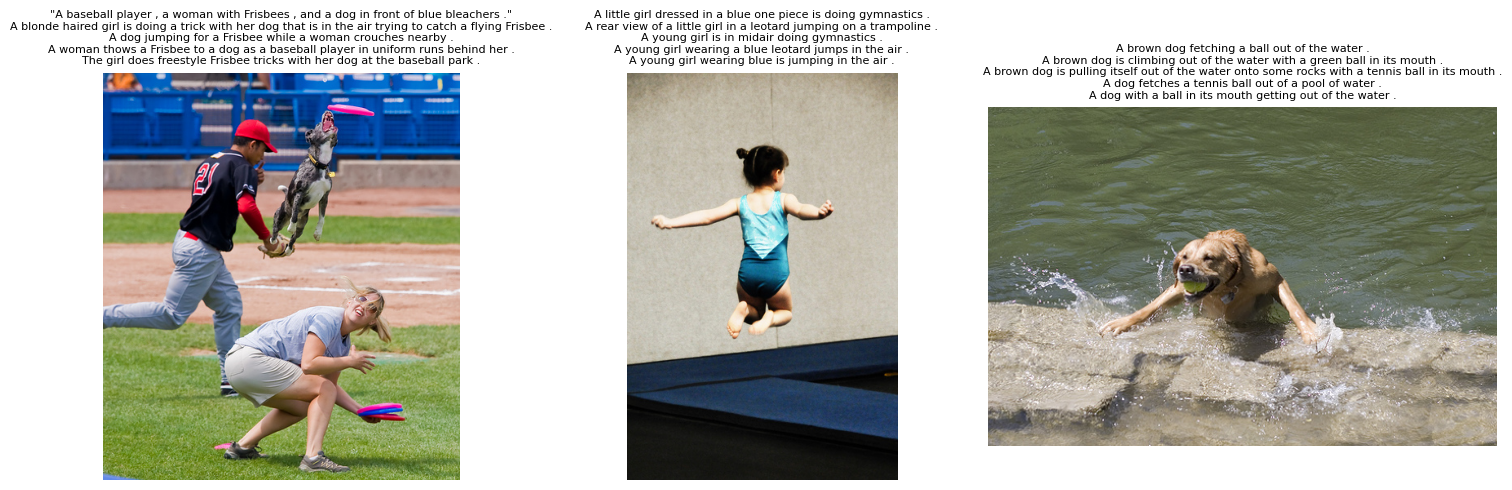

In [4]:
image_folder = "/kaggle/input/flicker8k-dataset/Flickr8k_Dataset/Flicker8k_Dataset/"
caption_file = "/kaggle/input/flicker8k-dataset/Flickr8k_text/Flickr8k.token.txt"

try:
  load_flickr8k_and_show_random_images(image_folder, caption_file, num_images=3)
except:
  #in colab
  !kaggle datasets download -d adityajn105/flickr8k
  !unzip flickr8k.zip -d flickr8k/
  image_folder = "/content/flickr8k/Images/"
  caption_file = "/content/flickr8k/captions.txt"
  load_flickr8k_and_show_random_images_colab(image_folder, caption_file, num_images=3)

---

### ◆ Images Preprocessing

#### resize images

In [5]:
def preprocess_images(image_folder, target_size=(224, 224)):
    resized_images = {}
    for image_file in os.listdir(image_folder):
        if image_file.endswith('.jpg'):
            image_path = os.path.join(image_folder, image_file)
            with Image.open(image_path) as img:
                img_resized = img.resize(target_size)
                img_array = np.array(img_resized)
                resized_images[image_file] = img_array
    return resized_images

In [6]:
images_dict = preprocess_images(image_folder)

#### rescale images

**since EfficientNetB0 uses pictures in range 0-255, we don't change pictures.**

---

### ◆ Captions Preprocessing

In [7]:
def preprocess_captions(captions_file):
    captions_dict = {}
    with open(captions_file, 'r') as file:
        for line in file:
            if image_folder.startswith('/content'):
                if line.startswith("image"):
                    continue
                parts = line.strip().split(".jpg,")
                image_file = parts[0].strip()
                image_file=f'{image_file}.jpg'
                # print(line)
                caption = parts[1].strip()
                caption_cleaned = re.sub(r"[^a-z\s]", "", caption)
                if image_file not in captions_dict:
                    captions_dict[image_file] = []
                captions_dict[image_file].append(caption_cleaned)
            else:
                parts = line.strip().split("#")
                image_file = parts[0].strip()
                if image_file.endswith('.jpg'):
                    caption = parts[1].split('\t')[1].strip().lower()
                    caption_cleaned = re.sub(r"[^a-z\s]", "", caption)
                    if image_file not in captions_dict:
                        captions_dict[image_file] = []
                    captions_dict[image_file].append(caption_cleaned)
    return captions_dict

In [8]:
captions_dict = preprocess_captions(caption_file)

#### tokenization

In [9]:
def tokenize_and_map_with_special_tokens(captions_dict, output_file="word_to_id.json"):
    all_words = []
    for captions in captions_dict.values():
        for caption in captions:
            all_words.extend(caption.split())
    word_counter = Counter(all_words)
    special_tokens = ["<pad>", "<sos>", "<eos>", "<unk>"]
    word_to_id = {token: idx for idx, token in enumerate(special_tokens)}
    word_to_id.update({word: idx + len(special_tokens) for idx, (word, _) in enumerate(word_counter.items())})
    tokenized_captions = {}
    for image, captions in captions_dict.items():
        tokenized_captions[image] = [
            [word_to_id["<sos>"]] +
            [word_to_id.get(word, word_to_id["<unk>"]) for word in caption.split()] +
            [word_to_id["<eos>"]]
            for caption in captions
        ]
    with open(output_file, "w") as json_file:
        json.dump(word_to_id, json_file, indent=4)
    return word_to_id, tokenized_captions

In [10]:
word_to_id, tokenized_captions = tokenize_and_map_with_special_tokens(captions_dict, "word_to_id.json")

In [11]:
def tokenize_and_pad_captions(captions_dict, word_to_id, caption_len):
    padded_captions = {}
    pad_id = word_to_id["<pad>"]
    sos_id = word_to_id["<sos>"]
    eos_id = word_to_id["<eos>"]
    unk_id = word_to_id["<unk>"]
    for image, captions in captions_dict.items():
        tokenized_padded_captions = []
        for caption in captions:
            tokenized_caption = [word_to_id.get(word, unk_id) for word in caption.split()]
            tokenized_caption = [sos_id] + tokenized_caption + [eos_id]
            if len(tokenized_caption) < caption_len:
                tokenized_caption += [pad_id] * (caption_len - len(tokenized_caption))
            else:
                tokenized_caption = tokenized_caption[:caption_len]
            tokenized_padded_captions.append(tokenized_caption)
        padded_captions[image] = tokenized_padded_captions
    return padded_captions

In [12]:
caption_len = 40
tokens_dict = tokenize_and_pad_captions(captions_dict, word_to_id, caption_len)

---

### ◆ Data Splitting

In [13]:
def sort_and_split_data(picture_dict, captions_dict, train_ratio=0.8, val_ratio=0.1, test_ratio=0.1):
    sorted_keys = sorted(picture_dict.keys())
    sorted_pictures = [picture_dict[key] for key in sorted_keys]
    sorted_captions = [captions_dict[key] for key in sorted_keys]
    total_count = len(sorted_keys)
    train_count = int(train_ratio * total_count)
    val_count = int(val_ratio * total_count)
    test_count = total_count - (train_count + val_count)
    indices = np.random.permutation(total_count)
    train_indices = indices[:train_count]
    val_indices = indices[train_count:train_count + val_count]
    test_indices = indices[train_count + val_count:]
    train_pictures = [sorted_pictures[i] for i in train_indices]
    train_captions = [sorted_captions[i] for i in train_indices]
    val_pictures = [sorted_pictures[i] for i in val_indices]
    val_captions = [sorted_captions[i] for i in val_indices]
    test_pictures = [sorted_pictures[i] for i in test_indices]
    test_captions = [sorted_captions[i] for i in test_indices]
    return train_pictures, train_captions, val_pictures, val_captions, test_pictures, test_captions

In [14]:
train_pictures, train_captions, val_pictures, val_captions, test_pictures, test_captions = sort_and_split_data(images_dict, tokens_dict)

---

### ◆ Displaying Processed Data

#### id to caption

In [15]:
def ids_to_caption(id_list, id_to_word):
    words = []
    for i in id_list:
        word = id_to_word.get(i, "<unk>")
        if word == "<sos>":
            continue
        if word == "<eos>":
            break
        words.append(word)
    return " ".join(words)

#### random plot

In [16]:
def plot_images_with_captions(train_pictures, train_captions, id_to_word, num_images=5):
    selected_indices = np.random.choice(len(train_pictures), num_images, replace=False)
    plt.figure(figsize=(5, 25))
    for i, idx in enumerate(selected_indices):
        image = train_pictures[idx]
        caption = train_captions[idx][0]
        caption = ids_to_caption(caption, id_to_word)[1:]
        plt.subplot(num_images, 1, i + 1)
        plt.imshow(image)
        plt.axis("off")
        plt.title(caption, fontsize=12)
    plt.tight_layout()
    plt.show()

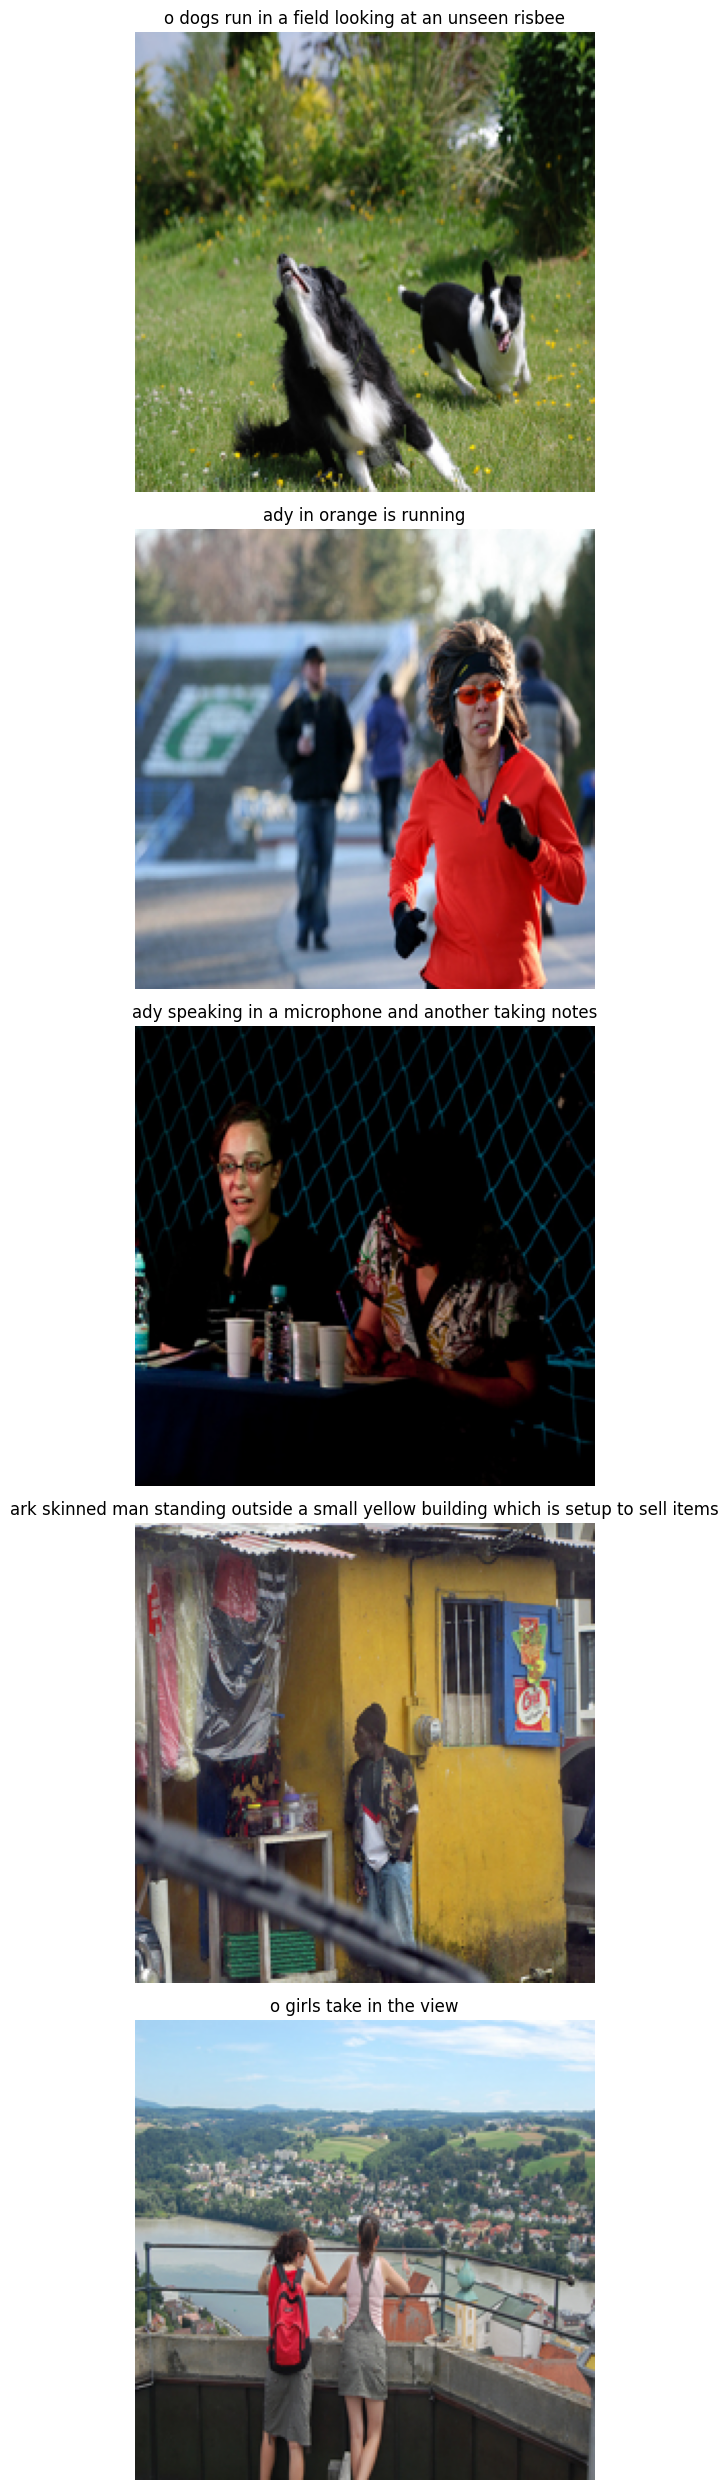

In [17]:
id_to_word = {v: k for k, v in word_to_id.items()}
plot_images_with_captions(train_pictures, train_captions, id_to_word)

#### scatter plot of caption lengths

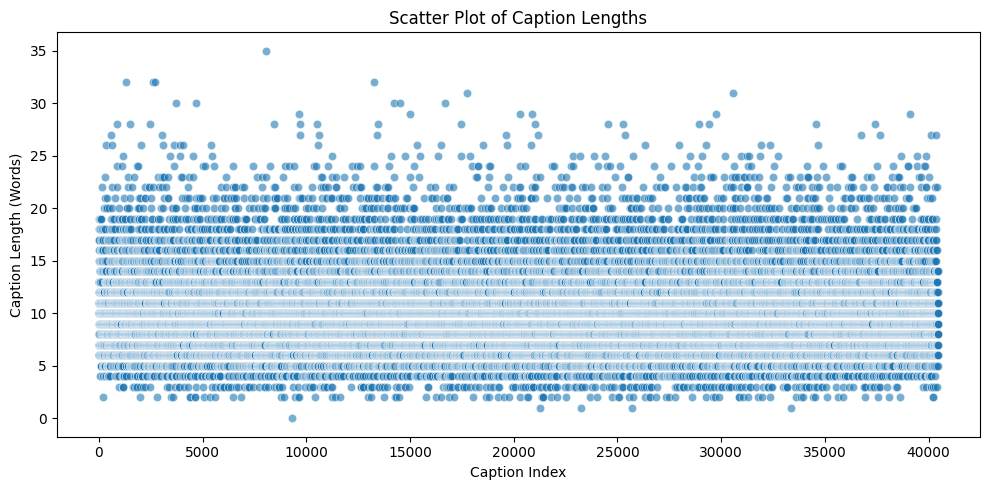

In [18]:
caption_lengths = []
for captions in captions_dict.values():
    for caption in captions:
        caption_lengths.append(len(caption.split()))  # Count words in caption
indices = range(len(caption_lengths))
plt.figure(figsize=(10, 5))
sns.scatterplot(x=indices, y=caption_lengths, alpha=0.6)
plt.xlabel("Caption Index")
plt.ylabel("Caption Length (Words)")
plt.title("Scatter Plot of Caption Lengths")
plt.tight_layout()
plt.show()

#### histogram of 20 most frequent words

<ipython-input-19-78bcf759ff0f>:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(words), y=list(counts), palette="viridis")


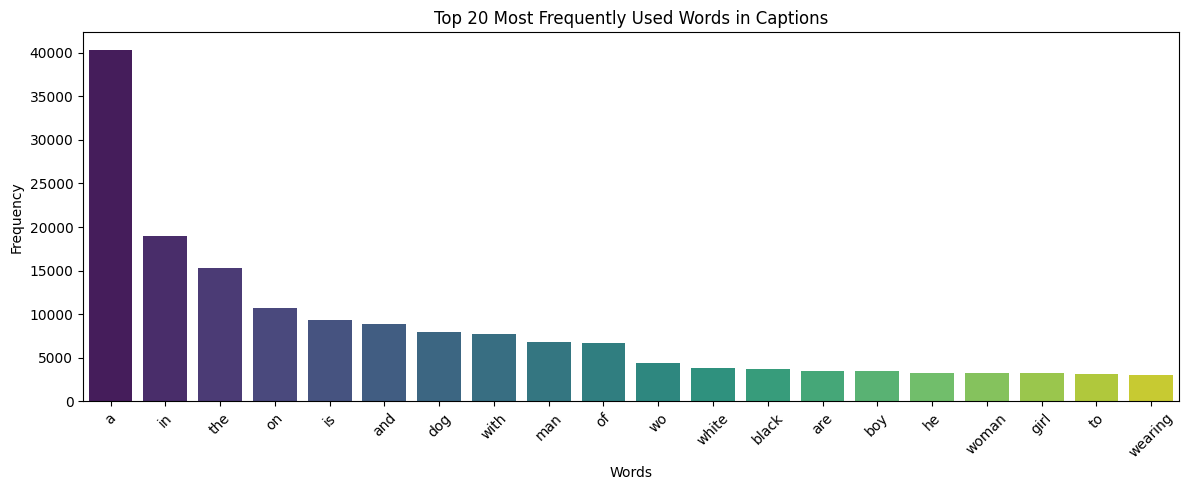

In [19]:
word_counter = Counter()
for captions in captions_dict.values():
    for caption in captions:
        words = caption.split()
        word_counter.update(words)
most_common_words = word_counter.most_common(20)
words, counts = zip(*most_common_words)
plt.figure(figsize=(12, 5))
sns.barplot(x=list(words), y=list(counts), palette="viridis")
plt.xticks(rotation=45)
plt.xlabel("Words")
plt.ylabel("Frequency")
plt.title(f"Top {20} Most Frequently Used Words in Captions")
plt.tight_layout()
plt.show()

---

<a name="2"></a>

> Add blockquote


## 1 - CNN RNN Implementation

def cnn_rnn_model(vocab_size, embedding_dim, lstm_units, max_caption_len):
    # --- Encoder (CNN: EfficientNetB0) ---
    cnn_base = EfficientNetB0(include_top=False, weights="imagenet", pooling="avg")
    cnn_base.trainable = False
    image_input = Input(shape=(224, 224, 3), name="image_input")
    encoded_image = cnn_base(image_input)
    image_features = Dense(lstm_units, activation="relu", name="image_features")(encoded_image)
    # --- Decoder (RNN: LSTMs) ---
    caption_input = Input(shape=(max_caption_len,), name="caption_input")
    embeddings = Embedding(input_dim=vocab_size, output_dim=embedding_dim, mask_zero=True, name="embedding")(caption_input)
    # Combine image features with LSTM inputs
    combined_input = Add(name="add_features")([tf.expand_dims(image_features, 1), embeddings])
    lstm_output = LSTM(lstm_units, return_sequences=True, name="lstm_1")(combined_input)
    lstm_output = LSTM(lstm_units, return_sequences=False, name="lstm_2")(lstm_output)
    # Output layer
    output = Dense(vocab_size, activation="softmax", name="output")(lstm_output)
    # --- Model ---
    model = Model(inputs=[image_input, caption_input], outputs=output, name="cnn_rnn_model")
    model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])
    return model

vocab_size = 5000          # Example vocabulary size
embedding_dim = 256        # Word embedding size
lstm_units = 32           # Number of LSTM units
model = cnn_rnn_model(vocab_size, embedding_dim, lstm_units, caption_len)
model.summary()

---

In [65]:
import torchvision.models as models
import torch

CNN = models.efficientnet_b0(weights=models.efficientnet.EfficientNet_B0_Weights.DEFAULT)
CNN.classifier = torch.nn.Identity()

inputs = torch.ones(1, 3, 224, 224)
outputs = CNN(inputs)

print(outputs.shape)

torch.Size([1, 1280])


In [66]:
for param in CNN.parameters():
    param.requires_grad = False

In [22]:
import torch.nn as nn

class Decoder(nn.Module):
    def __init__(self, embed_size, hidden_size, vocab_size):
        super(Decoder, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.lstm = nn.LSTM(embed_size, hidden_size, 1, batch_first=True)
        self.linear = nn.Linear(hidden_size, vocab_size)

    def forward(self, features, captions):
        embeddings = self.embedding(captions[:, :-2])
        inputs = torch.cat((features, embeddings), 1)
        hiddens, _ = self.lstm(inputs)
        outputs = self.linear(hiddens)

        return outputs

In [23]:
class ImageCaptioningModel(nn.Module):
    def __init__(self, embed_size, hidden_size, vocab_size):
        super(ImageCaptioningModel, self).__init__()
        self.encoder = CNN
        self.fc = nn.Linear(1280, embed_size)
        self.decoder = Decoder(embed_size, hidden_size, vocab_size)
        # print(outputs.shape, embed_size)

    def forward(self, images, captions):
        with torch.no_grad():
            features = self.encoder(images)
            # print(features.shape)
        features = self.fc(features)
        features = features.unsqueeze(1)

        outputs = self.decoder.forward(features, captions)
        # print(outputs.shape)
        return outputs

In [67]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image

class FlickrDataset(Dataset):
    def __init__(self, image_paths, captions, transform=None):
        self.image_paths = image_paths
        self.captions = captions
        self.transform = transform if transform is not None else transforms.ToTensor()

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = Image.fromarray(self.image_paths[idx]).convert('RGB')
        if self.transform:
            image = self.transform(image)

        caption = torch.tensor(self.captions[idx][0])

        return image, caption

train_dataset = FlickrDataset(train_pictures, train_captions)
val_dataset = FlickrDataset(val_pictures, val_captions)
test_dataset = FlickrDataset(test_pictures, test_captions)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [90]:
captions[:, :-2].shape

torch.Size([32, 38])

In [96]:
import torch.optim as optim
import torch.nn as nn
import torch.nn as nn

device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')

embed_size = 256
hidden_size = 512
vocab_size = len(word_to_id)
num_epochs = 10
learning_rate = 1e-3

model = ImageCaptioningModel(embed_size, hidden_size, vocab_size)
model.to(device)
criterion = nn.CrossEntropyLoss(ignore_index=word_to_id['<pad>'])
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

for epoch in range(num_epochs):
    for images, captions in train_loader:
        images=images.to(device)
        captions=captions.to(device)
        outputs = model(images, captions)
        outputs = outputs.reshape(-1, vocab_size)
        targets = captions[:, 1:].reshape(-1)

        # print(outputs.shape, targets.shape)
        loss = criterion(outputs, targets)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

Epoch [1/10], Loss: 5.2378
Epoch [2/10], Loss: 4.4384
Epoch [3/10], Loss: 4.2340
Epoch [4/10], Loss: 3.5750
Epoch [5/10], Loss: 3.8083
Epoch [6/10], Loss: 4.0648
Epoch [7/10], Loss: 3.6781
Epoch [8/10], Loss: 3.2997
Epoch [9/10], Loss: 2.8795
Epoch [10/10], Loss: 2.7777


Generated Caption: crowd people at art <eos>


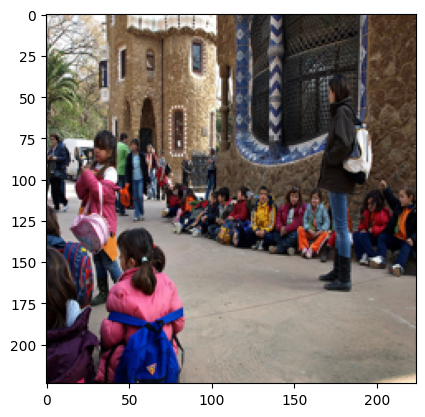

In [118]:
def generate_caption(model, image, word_to_id, max_length=30):
    model.eval()
    with torch.no_grad():
        feature = model.encoder(image.unsqueeze(0).to(device))
        feature = model.fc(feature).unsqueeze(1)

        inputs = feature
        states = None
        generated_indices = []

        for _ in range(max_length):
            hiddens, states = model.decoder.lstm(inputs, states)
            outputs = model.decoder.linear(hiddens.squeeze(1))
            predicted = outputs.argmax(1)
            generated_indices.append(predicted.item())
            if predicted.item() == word_to_id['<eos>']:
                break
            inputs = model.decoder.embedding(predicted).unsqueeze(1)

    generated_caption = [id_to_word.get(idx, '<unk>') for idx in generated_indices]
    return ' '.join(generated_caption)


image = test_dataset[0][0]
image = image.to(device)
caption = generate_caption(model, image, word_to_id)
print('Generated Caption:', caption)
plt.imshow(image.cpu().permute(1,2,0).numpy())

## 2-CNN-Attention

In [122]:
CNN.avgpool=nn.Identity()

In [125]:
inputs = torch.ones(1, 3, 224, 224).to(device)
outputs = CNN(inputs)

print(outputs.shape)

torch.Size([1, 62720])


### **FOLLOWING 2 CELLS ARE CHEATED, FIX IT**


In [126]:
class Attention(nn.Module):
    def __init__(self, encoder_dim):
        super(Attention, self).__init__()
        self.U = nn.Linear(512, 512)
        self.W = nn.Linear(encoder_dim, 512)
        self.v = nn.Linear(512, 1)
        self.tanh = nn.Tanh()
        self.softmax = nn.Softmax(1)

    def forward(self, img_features, hidden_state):
        U_h = self.U(hidden_state).unsqueeze(1)
        W_s = self.W(img_features)
        att = self.tanh(W_s + U_h)
        e = self.v(att).squeeze(2)
        alpha = self.softmax(e)
        context = (img_features * alpha.unsqueeze(2)).sum(1)
        return context, alpha

In [ ]:
import torch
import torch.nn as nn

class Decoder(nn.Module):
    def __init__(self, vocabulary_size, encoder_dim, tf=False):
        super(Decoder, self).__init__()
        self.use_tf = tf

        self.vocabulary_size = vocabulary_size
        self.encoder_dim = encoder_dim

        self.init_h = nn.Linear(encoder_dim, 512)
        self.init_c = nn.Linear(encoder_dim, 512)
        self.tanh = nn.Tanh()

        self.f_beta = nn.Linear(512, encoder_dim)
        self.sigmoid = nn.Sigmoid()

        self.deep_output = nn.Linear(512, vocabulary_size)
        self.dropout = nn.Dropout()

        self.attention = Attention(encoder_dim)
        self.embedding = nn.Embedding(vocabulary_size, 512)
        self.lstm = nn.LSTMCell(512 + encoder_dim, 512)

    def forward(self, img_features, captions):
        batch_size = img_features.size(0)

        h, c = self.get_init_lstm_state(img_features)
        max_timespan = max([len(caption) for caption in captions]) - 1

        prev_words = torch.zeros(batch_size, 1).long().cuda()
        if self.use_tf:
            embedding = self.embedding(captions) if self.training else self.embedding(prev_words)
        else:
            embedding = self.embedding(prev_words)

        preds = torch.zeros(batch_size, max_timespan, self.vocabulary_size).cuda()
        alphas = torch.zeros(batch_size, max_timespan, img_features.size(1)).cuda()
        for t in range(max_timespan):
            context, alpha = self.attention(img_features, h)
            gate = self.sigmoid(self.f_beta(h))
            gated_context = gate * context

            if self.use_tf and self.training:
                lstm_input = torch.cat((embedding[:, t], gated_context), dim=1)
            else:
                embedding = embedding.squeeze(1) if embedding.dim() == 3 else embedding
                lstm_input = torch.cat((embedding, gated_context), dim=1)

            h, c = self.lstm(lstm_input, (h, c))
            output = self.deep_output(self.dropout(h))

            preds[:, t] = output
            alphas[:, t] = alpha

            if not self.training or not self.use_tf:
                embedding = self.embedding(output.max(1)[1].reshape(batch_size, 1))
        return preds, alphas

    def get_init_lstm_state(self, img_features):
        avg_features = img_features.mean(dim=1)

        c = self.init_c(avg_features)
        c = self.tanh(c)

        h = self.init_h(avg_features)
        h = self.tanh(h)

        return h, c

In [ ]:
class ImageCaptioningModel(nn.Module):
    def __init__(self, embed_size, hidden_size, vocab_size):
        super(ImageCaptioningModel, self).__init__()
        self.encoder = CNN
        self.fc = nn.Linear(1280 * 7 * 7, embed_size)
        self.decoder = Decoder(vocab_size, embed_size)

    def forward(self, images, captions):
        with torch.no_grad():
            features = self.encoder(images)
        features = features.reshape(features.size(0), -1)
        features = self.fc(features)
        features = features.unsqueeze(1)

        outputs = self.decoder.forward(features, captions)
        return outputs


In [139]:
import torch.optim as optim
import torch.nn as nn

embed_size = 256
hidden_size = 512
vocab_size = len(word_to_id)
num_epochs = 10
learning_rate = 1e-3

model = ImageCaptioningModel(embed_size, hidden_size, vocab_size)
model.to(device)
criterion = nn.CrossEntropyLoss(ignore_index=word_to_id['<pad>'])
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

for epoch in range(num_epochs):
    for images, captions in train_loader:
        images=images.to(device)
        captions=captions.to(device)
        outputs,_ = model(images, captions)
        outputs = outputs.reshape(-1, vocab_size)
        targets = captions[:, 1:].reshape(-1)

        # print(outputs.shape, targets.shape)
        loss = criterion(outputs, targets)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

Epoch [1/10], Loss: 5.4166
Epoch [2/10], Loss: 5.6874
Epoch [3/10], Loss: 4.8494
Epoch [4/10], Loss: 4.6182
Epoch [5/10], Loss: 5.7871
Epoch [6/10], Loss: 4.9759
Epoch [7/10], Loss: 4.4567
Epoch [8/10], Loss: 5.4434
Epoch [9/10], Loss: 5.1474
Epoch [10/10], Loss: 4.7558


Generated Caption: black is a a a a <eos>


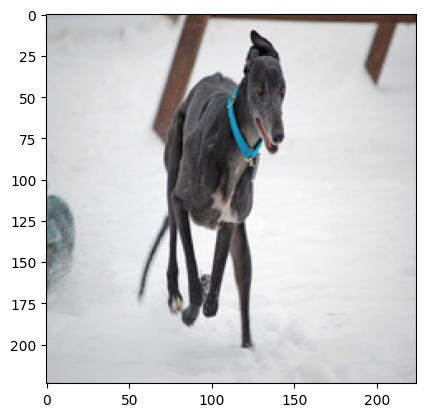

In [171]:
def generate_caption(model, image, word_to_id, id_to_word, max_length=30):
    model.eval()
    with torch.no_grad():
        features = model.encoder(image.unsqueeze(0).to(device))
        features = features.reshape(features.size(0), -1)
        features = model.fc(features)
        features = features.unsqueeze(1)

        h, c = model.decoder.get_init_lstm_state(features)

        inputs = model.decoder.embedding(torch.tensor([[word_to_id['<sos>']]]).to(device))

        generated_indices = []

        for _ in range(max_length):
            context, alpha = model.decoder.attention(features, h)
            gate = model.decoder.sigmoid(model.decoder.f_beta(h))
            gated_context = gate * context
            gated_context = gated_context.unsqueeze(0) if gated_context.dim() == 1 else gated_context
            lstm_input = torch.cat((inputs.squeeze(1), gated_context), dim=1)
            lstm_input = lstm_input.unsqueeze(1)
            h, c = model.decoder.lstm(lstm_input.squeeze(1), (h, c))
            output = model.decoder.deep_output(model.decoder.dropout(h))
            predicted = output.argmax(1)
            generated_indices.append(predicted.item())
            if predicted.item() == word_to_id['<eos>']:
                break
            inputs = model.decoder.embedding(predicted).unsqueeze(1)

    generated_caption = [id_to_word.get(idx, '<unk>') for idx in generated_indices]
    return ' '.join(generated_caption)

image = test_dataset[2][0]
image = image.to(device)
caption = generate_caption(model, image, word_to_id, id_to_word)
print('Generated Caption:', caption)
plt.imshow(image.cpu().permute(1, 2, 0).numpy())

## 3-CNN-Transformer